# Replication of Koala Habitat Fire-Risk Analysis
This notebook uses the code provided by the original study. 
Changes in the original code are noted and commented.
Data and Folder paths need to be changed based on the user's paths and working directories. These changes are commented.

# Koala Habitat Fire‑Risk Analysis

This notebook provides a **step‑by‑step, for analysing the overlap between koala habitat suitability and the Forest Fire Danger Index (FFDI) from 2013‑2023.  

The analysis is organised into four clear sections:

1. **Categorise** each koala polygon by mean FFDI and habitat suitability  
2. **Cluster** polygons by their mean FFDI and visualise the spatial distribution  
3. **Box‑plot** monthly FFDI for the 15 largest high‑suitability polygons  
4. **Heat‑map** the percentage of each polygon that is under high risk (FFDI ≥ 12)



## Section 1 – Categorise Koala Habitat by Mean FFDI and Suitability

In [1]:
"""
Section 1 – Categorise Koala Habitat by Mean FFDI and Suitability

This cell performs the entire workflow for section 1 – categorise koala habitat by mean ffdi and suitability.

"""

import geopandas as gpd
import os
import pandas as pd
from rasterstats import zonal_stats
from tqdm import tqdm
import numpy as np

# === USER INPUT === changed to replication study paths

shapefile_path = "Outputs/study_suitability_map.gpkg"       # CHANGE to location user path and current working directory
suitability_field = "suitability"  # column with 1 = low, 2 = high    ====== replication same as study

ffdi_folder = "Outputs/ffdi"                   # CHANGE to location user path and current working directory
output_path = "Outputs/koala_categorized.shp"  # CHANGE to location user path and current working directory

# === 1. Load polygon data ===
gdf = gpd.read_file(shapefile_path)
gdf = gdf.to_crs("EPSG:4326")  # Match raster CRS

0      2
1      1
2      1
3      1
4      2
      ..
166    2
167    1
168    1
169    2
170    0
Name: suitability, Length: 171, dtype: int64


<AxesSubplot: >

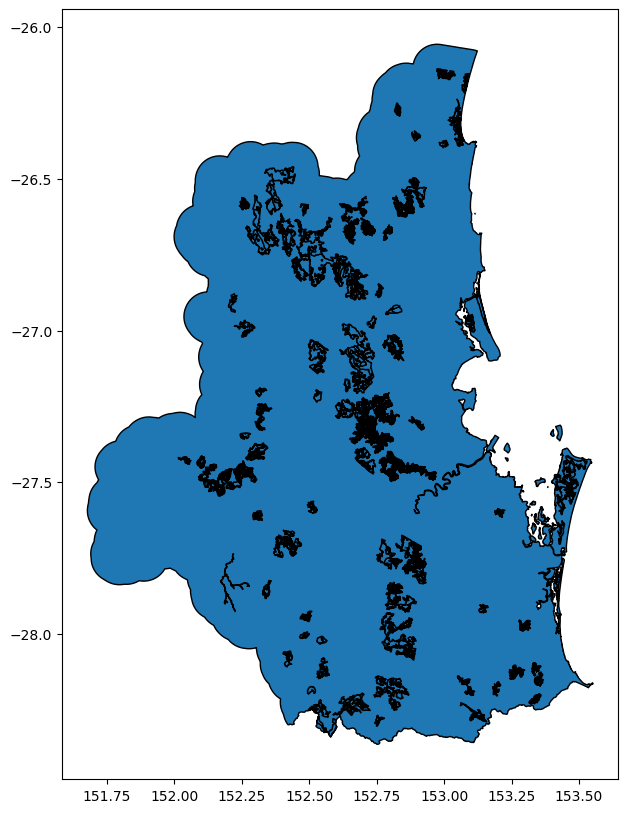

In [2]:
print(gdf.suitability)
# Plot the shapefile
gdf.plot(figsize=(10, 10), edgecolor="black")

In [3]:
# === 2. List and sort FFDI raster files ===
ffdi_files = sorted([
    os.path.join(ffdi_folder, f) for f in os.listdir(ffdi_folder) if f.endswith(".tif")
])
dates = [os.path.basename(f).replace(".tif", "").replace("ffdi_", "") for f in ffdi_files]

# === 3. Zonal statistics: mean FFDI per polygon per month ===
mean_records = []
print("🔄 Calculating mean FFDI for all polygons over all months...")

for date, tif in tqdm(zip(dates, ffdi_files), total=len(ffdi_files)):
    stats = zonal_stats(gdf, tif, stats=['mean'], nodata=-9999, all_touched=True) #zonal_stats(gdf, tif, stats=['mean'], nodata=-9999, all_touched=True)
    mean_values = [s['mean'] if s['mean'] is not None else np.nan for s in stats]
    mean_records.append(mean_values)

# === 4. Create DataFrame of means ===
mean_ffdi_df = pd.DataFrame(mean_records, index=dates).T  # shape: (polygons, dates)
gdf["mean_ffdi"] = mean_ffdi_df.mean(axis=1, skipna=True)

🔄 Calculating mean FFDI for all polygons over all months...


100%|██████████| 132/132 [03:14<00:00,  1.48s/it]


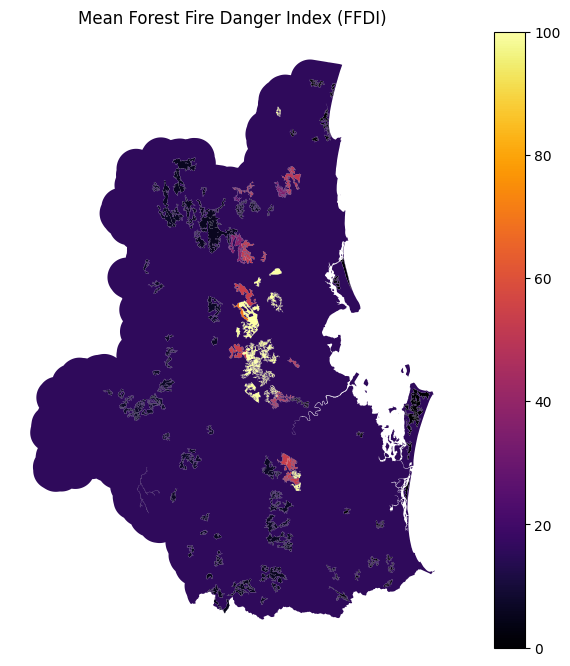

In [4]:
# ==================== Code added in Replication for visualization purposes ============================
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

gdf.plot(
    column="mean_ffdi",
    ax=ax,
    legend=True,
    cmap="inferno",   # great for fire metrics 🔥
    missing_kwds={
        "color": "lightgrey",
        "label": "No data"
    }
)

ax.set_title("Mean Forest Fire Danger Index (FFDI)")
ax.axis("off")
plt.show()

# (optional) Save the plot to a PNG by removing "#" 
#plt.savefig("mean_ffdi.png", dpi=300, bbox_inches='tight')

In [9]:
# Save the plot to a file =========== PNG
plt.savefig("Outputs/mean_ffdi.png", dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

In [10]:
# === 5. Assign default class if values are missing ===
def classify(row):
    suit = row[suitability_field]
    ffdi = row["mean_ffdi"]

    # Fill missing suitability with 1 (Low) and missing FFDI with median of all polygons
    if pd.isna(suit):
        suit = 1 
    if pd.isna(ffdi):
        ffdi = gdf["mean_ffdi"].median()

    suit = int(suit)

    if suit == 1 and ffdi <= 12:  
        return "Low Suitability – Low Risk"
    elif suit == 1 and ffdi > 12:  
        return "Low Suitability – High Risk"
    elif suit == 2 and ffdi <= 12:  
        return "High Suitability – Low Risk"
    elif suit == 2 and ffdi > 12:  
        return "High Suitability – High Risk"
    else:
        return "Low Suitability – Low Risk"  # Safe fallback

# === 6. Apply classification
gdf["RiskSuitabilityCategory"] = gdf.apply(classify, axis=1)

# === 7. Summary
category_counts = gdf["RiskSuitabilityCategory"].value_counts()
print("\n Category counts:")
print(category_counts)

# === 8. Save as .shp
gdf.to_file(output_path, driver="ESRI Shapefile")
print(f"\n Shapefile saved to: {output_path}")


 Category counts:
Low Suitability – Low Risk      75
High Suitability – Low Risk     43
Low Suitability – High Risk     36
High Suitability – High Risk    17
Name: RiskSuitabilityCategory, dtype: int64


/tmp/ipykernel_3246/2554907820.py:34: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(output_path, driver="ESRI Shapefile")



 Shapefile saved to: Outputs/koala_categorized.shp


## Section 2 – K‑means Clustering of Polygons by Mean FFDI
In replication, sklearn.cluster was unable to operate for the Kmeans execution. sklearn was not compatible with the Juptyer environment. When attempting to reinstall scikit-learn from the source in a separate terminal, container permisisons prevented installing this without admin accesses. Therefore, sklearn was avoided by using SciPy for KMeans.

In [11]:
"""
Section 2 – K‑means Clustering of Polygons by Mean FFDI

This cell performs the entire workflow for section 2 – k‑means clustering of polygons by mean ffdi.

"""
import geopandas as gpd
import rasterio
import rasterio.mask
import os
import pandas as pd
import matplotlib.pyplot as plt
from rasterstats import zonal_stats
# from sklearn.cluster import KMeans  ========== Original Study KMeans Method
from tqdm import tqdm

#import instead  =============================== Replication Study KMeans Method
import numpy as np
from scipy.cluster.vq import kmeans2

# === USER INPUT ===
gpkg_path = "Outputs/study_suitability_map.gpkg"   # CHANGE to location user path and current working directory
ffdi_folder = "Outputs/ffdi"                       # CHANGE to location user path and current working directory
n_clusters = 3    # number of clusters used in original study
output_shapefile = gpkg_path.replace(".shp", "_with_clusters.shp")
output_plot = "Outputs/koala_cluster_boxplot.png"  # CHANGE to location user path and current working directory


In [12]:
# === 1. Load the vector data ===
gdf = gpd.read_file(gpkg_path)
gdf = gdf.to_crs("EPSG:4326")

# === 2. List FFDI raster files ===
ffdi_files = sorted([
    os.path.join(ffdi_folder, f) for f in os.listdir(ffdi_folder)
    if f.endswith(".tif") and f.startswith("ffdi_")
])
dates = [os.path.basename(f).replace(".tif", "").replace("ffdi_", "") for f in ffdi_files]

# ===================== Replication: Fix date parsing issue ========
#dates = pd.to_datetime(dates)   # Original code created date parsing errors
dates = pd.to_datetime(dates, format="%Y_%m")    # Additional formatting in replication code

In [13]:
# === 3. Compute mean FFDI for clustering ===
print("Computing mean FFDI for clustering...")
mean_ffdi_per_polygon = []

for tif in tqdm(ffdi_files):
    stats = zonal_stats(gdf, tif, stats=['mean'], nodata=-9999)
    mean_ffdi_per_polygon.append([s['mean'] if s['mean'] is not None else 0 for s in stats])

ffdi_mean_df = pd.DataFrame(mean_ffdi_per_polygon, index=dates).T

Computing mean FFDI for clustering...


100%|██████████| 132/132 [03:18<00:00,  1.50s/it]


# Clustering in Replication
During the replication, there were issues when trying to run the clustering code. As mentioned, sklearn.cluster was replaced with SciPy KMeans for the replication.
Additionally, the number of clusters used in the original study gave warnings for empty clusters. Therefore, additional steps were taken to analyze outlier polygons and optimal numbers of clusters. 

**Number of Clusters: 3** 
To follow the original study, 3 clusters were originally used. However, this yield 2 clusters with only one polygon. After visualization, one outlier (polygon 170) appears to be the no habitat polygon (suitability = 0), while the other outlier (polygon 136) has a mean FFDI of 100. 

**Number of Clusters: 2**
Next, 2 clusters were used instead to try and limit the effects of the outliers. However, polygon 136 is still identified as an outlier. With all other polygons assigned to another cluster.

**Number of Clusters: 5**
Clustering was tried with a higher number of clusters (5) to see if this would separate the grouped polygons into other clusters. However, this still collapses to 3 clusters (1 = 1, 2 = 1, 3 = 169). This indicates that the difference between the other 169 polygons remain minimal, and stay clustered dispite the number of clusters used. 

In [14]:
# === 4. Cluster polygons based on their mean time series ===

# ===========================================  Original Study Code using sklearn.cluster
#print("Clustering polygons...")
#kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
#gdf['cluster'] = kmeans.fit_predict(ffdi_mean_df) + 1  # convert 0,1,2 to 1,2,3

#=========================================== Replication Code NOT using sklearn
# === 4. Cluster polygons based on their mean time series ===
print("Clustering polygons (SciPy kmeans2)...")

# Convert DataFrame to NumPy array
X = ffdi_mean_df.to_numpy()

# Optional but recommended: standardise time series
X = (X - X.mean(axis=0)) / X.std(axis=0)

# Run k-means
centroids, labels = kmeans2(
    X,
    k=n_clusters,
    minit='points'
)

# Assign clusters (convert 0,1,2 → 1,2,3)
gdf['cluster'] = labels + 1

# ====================== Additional Replication Information ===============================
# Count how many polygons are in each cluster
print(gdf['cluster'].value_counts().sort_index())

#identify outlier
cluster_counts = gdf['cluster'].value_counts()
outlier_indices = gdf[gdf['cluster'].isin(cluster_counts[cluster_counts <= 2].index)].index.tolist()
print("Outlier polygon indices:", outlier_indices)

Clustering polygons (SciPy kmeans2)...
1      1
2      1
3    169
Name: cluster, dtype: int64
Outlier polygon indices: [136, 170]


/usr/local/lib/python3.8/dist-packages/scipy/cluster/vq.py:607: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


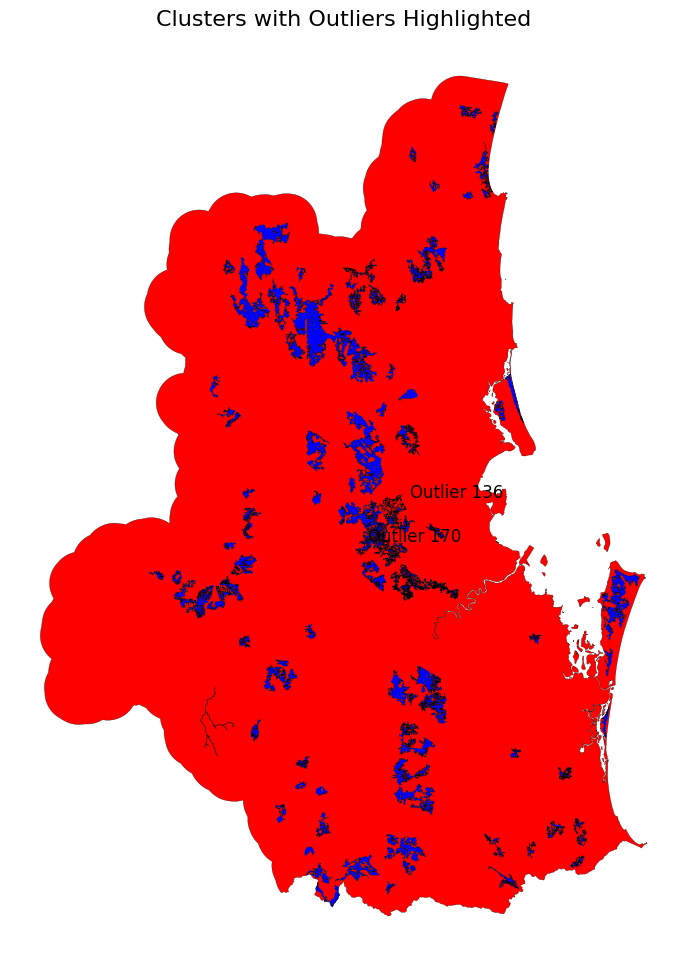

In [15]:
# ====================== Additional Replication Visualization ===============================
# Copy clusters for plotting
gdf['cluster_plot'] = gdf['cluster']

# Define outlier clusters
outlier_clusters = [1, 2]

# Assign a special value for outliers
gdf.loc[gdf['cluster'].isin(outlier_clusters), 'cluster_plot'] = 99

# Colors: main cluster(s) in blue, outliers in black
cluster_colors = {
    3: 'blue',   # main cluster
    99: 'red'  # outliers
}

fig, ax = plt.subplots(figsize=(12, 12))

# Plot clusters and outliers
for clust_id, color in cluster_colors.items():
    subset = gdf[gdf['cluster_plot'] == clust_id]
    subset.plot(
        ax=ax,
        color=color, 
        edgecolor= 'black',
        linewidth=0.20
    )

# Add labels for outliers
for idx in gdf[gdf['cluster_plot'] == 99].index:
    poly = gdf.loc[idx, 'geometry']
    x, y = poly.centroid.x, poly.centroid.y
    plt.text(x + 0.2, y + 0.01, f"Outlier {idx}", color='black',
             fontsize=12, ha='center', va='bottom')

plt.title("Clusters with Outliers Highlighted", fontsize=16)
plt.axis('off')
plt.show()


# Trying with 2 clusters

Clustering polygons (SciPy kmeans2)...
1      1
2    170
Name: cluster, dtype: int64
Outlier polygon indices: [136]


/usr/local/lib/python3.8/dist-packages/scipy/cluster/vq.py:607: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


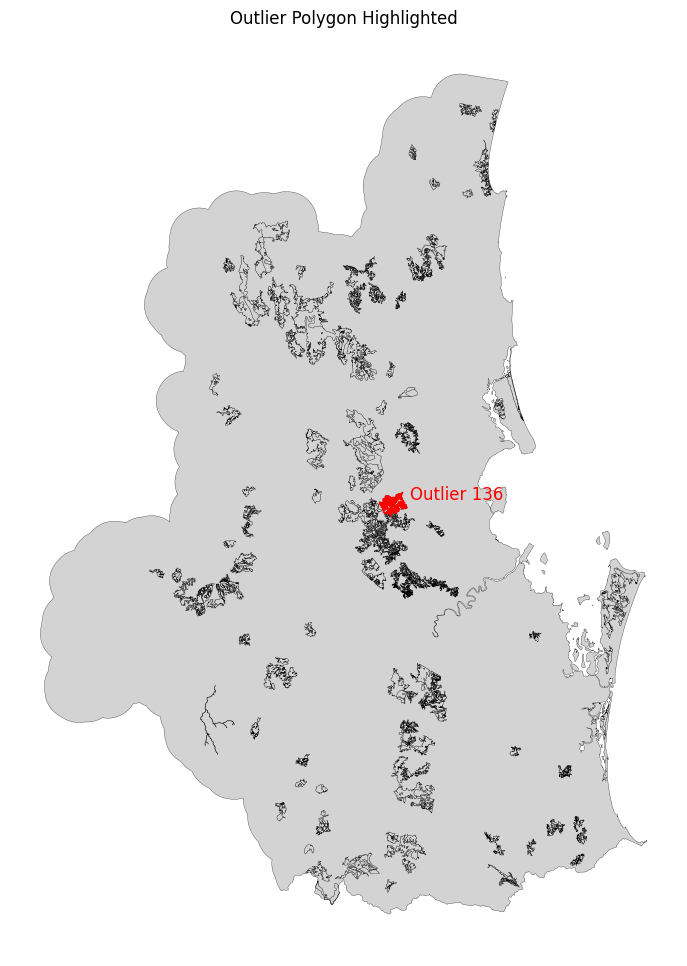

Outlier row
     FID_L2Core              HSM_VALUE  HSM_CATEGO   MCOVER      AREA_HA  \
136     19405.0  General habitat known         6.0  Remnant  1696.423931   

        Shape_Leng    Shape_Area  suitability  \
136  207570.974785  2.156407e+07            1   

                                              geometry  cluster  cluster_plot  
136  POLYGON ((152.79241 -27.20919, 152.79208 -27.2...        1            99  
 
Outlier FFDI
2013-01-01    100.0
2013-02-01    100.0
2013-03-01    100.0
2013-04-01    100.0
2013-05-01    100.0
              ...  
2023-08-01    100.0
2023-09-01    100.0
2023-10-01    100.0
2023-11-01    100.0
2023-12-01    100.0
Name: 136, Length: 132, dtype: float64


In [16]:
new_clusters = 2

#=== Replication Code NOT using sklearn
# === 4. Cluster polygons based on their mean time series ===
print("Clustering polygons (SciPy kmeans2)...")

# Convert DataFrame to NumPy array
X = ffdi_mean_df.to_numpy()

# Optional but recommended: standardise time series
X = (X - X.mean(axis=0)) / X.std(axis=0)

# Run k-means
centroids, labels = kmeans2(
    X,
    k=new_clusters,
    minit='points'
)

# Assign clusters (convert 0,1,2 → 1,2,3)
gdf['cluster'] = labels + 1


# Count how many polygons are in each cluster
print(gdf['cluster'].value_counts().sort_index())

#identify outlier
cluster_counts = gdf['cluster'].value_counts()
outlier_indices = gdf[gdf['cluster'].isin(cluster_counts[cluster_counts <= 2].index)].index.tolist()
print("Outlier polygon indices:", outlier_indices)



# =================== Plotting Outlier Polygon for visualization =================================

# Plot main cluster polygons in gray
base = gdf[gdf['cluster'] == 2].plot(color='lightgray', edgecolor='black', linewidth=0.2, figsize=(12, 12))

# Plot outlier in red
gdf[gdf['cluster'] == 1].plot(ax=base, color='red', edgecolor='red')

# Add label
outlier_geom = gdf.loc[136, 'geometry']
x, y = outlier_geom.centroid.x, outlier_geom.centroid.y
plt.text(x + 0.2, y + 0.01, "Outlier 136", color='red', fontsize=12, ha='center')

plt.title("Outlier Polygon Highlighted")
plt.axis('off')
plt.show()

# ======= Outlier Information ========
outlier_row = gdf.loc[[136]]  # double brackets to keep it as a DataFrame
print("Outlier row")
print(outlier_row)

outlier_ffdi = ffdi_mean_df.iloc[136]

print(" ")
print("Outlier FFDI")
print(outlier_ffdi)

# Using two clusters to progress with original study code

In [17]:
# === 5. Collect pixel-level FFDI values per cluster over time ===
print("Collecting all pixel values for boxplot...")
cluster_pixel_values_by_date = {c: [[] for _ in range(len(dates))] for c in range(1, n_clusters + 1)}

for i, tif in enumerate(tqdm(ffdi_files)):
    with rasterio.open(tif) as src:
        for idx, geom in enumerate(gdf.geometry):
            try:
                out_image, _ = rasterio.mask.mask(src, [geom], crop=True, nodata=-9999)
                data = out_image[0]
                values = data[data != -9999]
                cluster = gdf.iloc[idx]['cluster']
                cluster_pixel_values_by_date[cluster][i].extend(values.tolist())
            except Exception:
                continue

100%|██████████| 132/132 [03:30<00:00,  1.60s/it]


Plotting and saving boxplot...


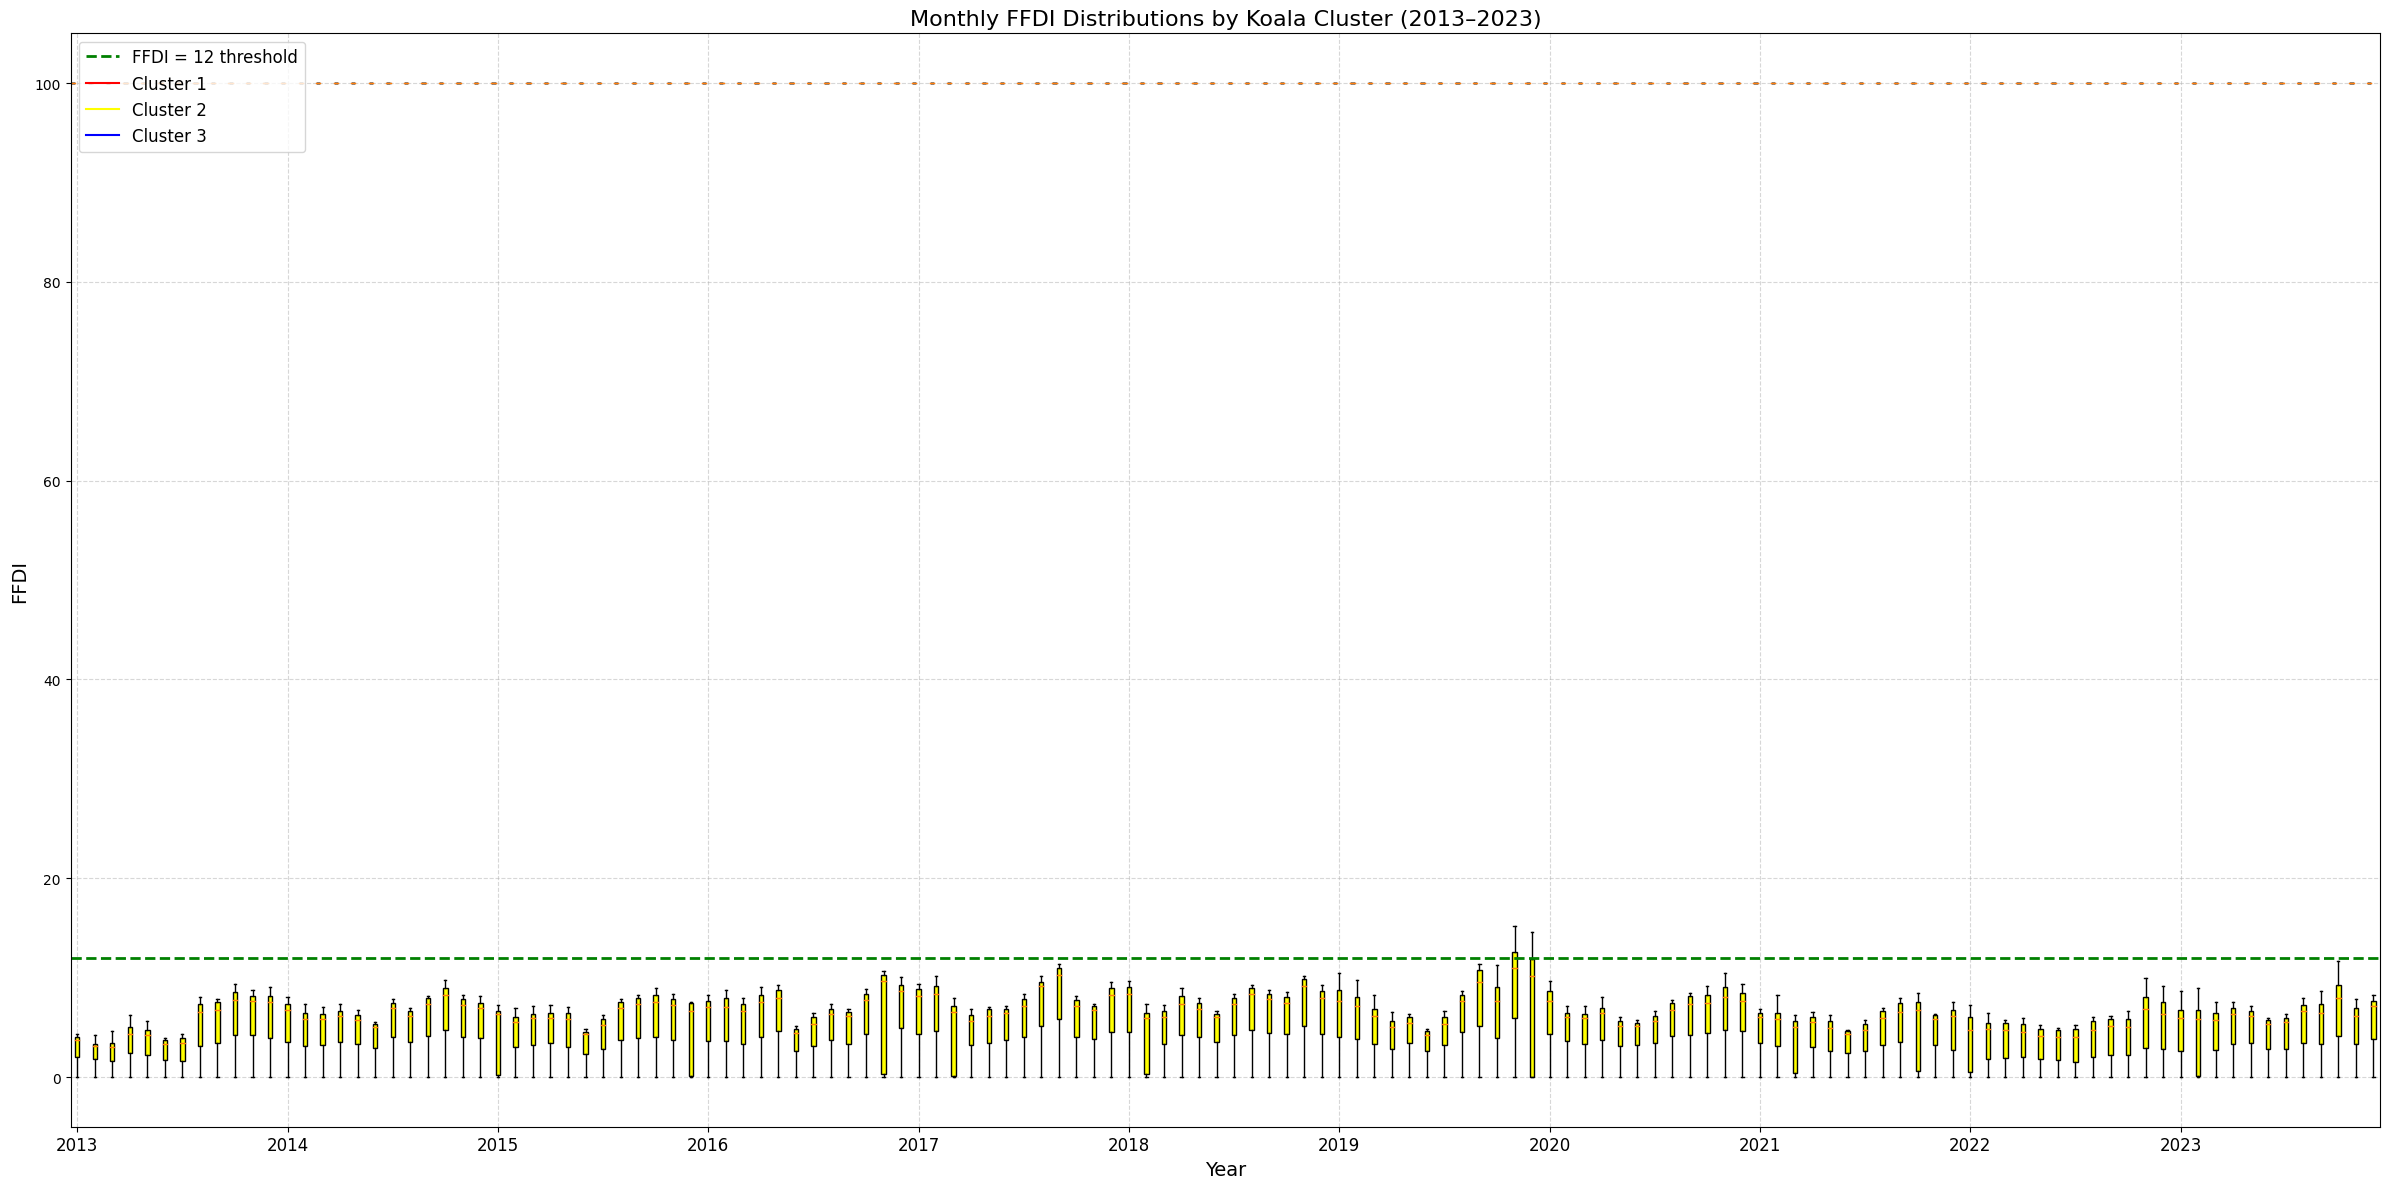

Saving spatial clustered map to: Outputs/study_suitability_map.gpkg
 Done!


In [18]:
# === 6. Create and save boxplots ===
print("Plotting and saving boxplot...")
cluster_colors = ['red', 'yellow', 'blue']
plt.figure(figsize=(24, 12))

positions = []
box_data = []
colors = []
legend_labels = []

for t_idx in range(len(dates)):
    for c in range(1, n_clusters + 1):
        box_data.append(cluster_pixel_values_by_date[c][t_idx])
        positions.append(t_idx * (n_clusters + 1) + (c - 1))
        colors.append(cluster_colors[c - 1])
        if t_idx == 0:  # For legend
            legend_labels.append(f"Cluster {c}")

bp = plt.boxplot(box_data, positions=positions, patch_artist=True, widths=1.0, showfliers=False)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Add FFDI threshold line
plt.axhline(y=12, color='green', linestyle='--', linewidth=2, label='FFDI = 12 threshold')

# Legend
for c_idx, label in enumerate(legend_labels):
    plt.plot([], c=cluster_colors[c_idx], label=label)
plt.legend(loc="upper left", fontsize=12)

# Set x-axis ticks to yearly intervals only
years = sorted(set(d.year for d in dates))
year_positions = [i * (n_clusters + 1) * 12 + 1 for i in range(len(years))]
plt.xticks(ticks=year_positions, labels=years, fontsize=12)

plt.title("Monthly FFDI Distributions by Koala Cluster (2013–2023)", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("FFDI", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig(output_plot, dpi=300)
plt.show()

# === 7. Save clustered spatial map ===
print(f"Saving spatial clustered map to: {output_shapefile}")
gdf.to_file(output_shapefile)

print(" Done!")

## Section 3 – Monthly FFDI Box‑plots for the 15 Largest High‑Suitability Polygons
In replication, the output box plots remain empty.
Steps included to check any issues are also included, but this issue was not resolved.

In [20]:
"""
Section 3 – Monthly FFDI Box‑plots for the 15 Largest High‑Suitability Polygons

This cell performs the entire workflow for section 3 – monthly ffdi box‑plots for the 15 largest high‑suitability polygons.

"""

import geopandas as gpd
import rasterio
import rasterio.mask
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# === USER INPUT ===
gpkg_path = "Outputs/study_suitability_map.gpkg"   # CHANGE to location user path and current working directory
ffdi_folder = "Outputs/ffdi"                       # CHANGE to location user path and current working directory
output_folder = "Outputs/"

# === 1. Load vector data ===
gdf = gpd.read_file(gpkg_path)
gdf = gdf.to_crs("EPSG:4326")

# === 2. Filter for suitability class 2 ===
suit_col = [col for col in gdf.columns if "suit" in col.lower()][0]
suit2_gdf = gdf[gdf[suit_col] == 2].copy()

# === 3. Calculate area and select largest 15 polygons ===
suit2_gdf["area_km2"] = suit2_gdf.geometry.to_crs(epsg=6933).area / 1e6  # km²
top15_gdf = suit2_gdf.sort_values("area_km2", ascending=False).head(15).reset_index(drop=True)

# === 4. List FFDI raster files ===
ffdi_files = sorted([
    os.path.join(ffdi_folder, f) for f in os.listdir(ffdi_folder)
    if f.endswith(".tif") and f.startswith("ffdi_")
])
dates = [os.path.basename(f).replace(".tif", "").replace("ffdi_", "") for f in ffdi_files]
# ======================= Replication Fix date parsing issue ========================
#dates = pd.to_datetime(dates)
dates = pd.to_datetime(dates, format="%Y_%m")  # datetime again fixed with additional formatting in replication

# === 5. Extract pixel-level FFDI values per polygon per month ===
print("Extracting FFDI pixel values...")
polygon_pixel_ffdi = {i: [[] for _ in range(len(dates))] for i in range(15)}

#  ============ Original Code =======================
#for t_idx, tif in enumerate(tqdm(ffdi_files)):
#    with rasterio.open(tif) as src:
#        for i, geom in enumerate(top15_gdf.geometry):
#            try:
#                out_image, _ = rasterio.mask.mask(src, [geom], crop=True, nodata=-9999)
#                data = out_image[0]
#                values = data[data != -9999]
#                polygon_pixel_ffdi[i][t_idx].extend(values.tolist())
#            except Exception:
#                continue

# Reprojection to crs =====================
for t_idx, tif in enumerate(tqdm(ffdi_files)):
    with rasterio.open(tif) as src:
        # Reproject polygons to the raster CRS
        geom_proj = top15_gdf.geometry.to_crs(src.crs)
        
        for i, geom in enumerate(geom_proj):
            try:
                nodata_val = src.nodata if src.nodata is not None else -9999
                out_image, _ = rasterio.mask.mask(src, [geom], crop=True, nodata=nodata_val)
                data = out_image[0]
                values = data[data != nodata_val]
                polygon_pixel_ffdi[i][t_idx].extend(values.tolist())
            except Exception as e:
                print(f"Polygon {i}, raster {tif} skipped: {e}")
                continue

# === 6. Plot and Save in Two Portrait Pages ===
def plot_page(polygons, page_num, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(8.3, 11.7))  # A4 portrait in inches
    axes = axes.flatten()
    for i, poly_idx in enumerate(polygons):
        ax = axes[i]
        box_data = polygon_pixel_ffdi[poly_idx]
        bp = ax.boxplot(box_data, patch_artist=True, widths=0.5, showfliers=False)

        for box in bp['boxes']:
            box.set_facecolor("lightblue")
            box.set_edgecolor("blue")

        area_km2 = top15_gdf.loc[poly_idx, "area_km2"]
        ax.set_title(f"Polygon {poly_idx + 1} | Area: {area_km2:.2f} km²", fontsize=10)
        ax.grid(True, linestyle="--", alpha=0.5)
        ax.set_ylim(0, 50)  # Fixed Y-axis range for all subplots

        xticks = list(range(0, len(dates), 12))
        xtick_labels = [dates[j].strftime("%Y") for j in xticks]
        ax.set_xticks(xticks)
        ax.set_xticklabels(xtick_labels, rotation=45, fontsize=8)
        ax.tick_params(axis='y', labelsize=8)

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(f"FFDI Boxplots – Page {page_num}", fontsize=14)
    fig.text(0.5, 0.04, 'Year (Monthly Data)', ha='center', fontsize=12)
    fig.text(0.06, 0.5, 'FFDI', va='center', rotation='vertical', fontsize=12)
    plt.tight_layout(rect=[0.08, 0.06, 0.95, 0.94])

    out_path = os.path.join(output_folder, f"ffdi_boxplots_page{page_num}.png")
    plt.savefig(out_path, dpi=300)
    plt.close()
    print(f"Saved: {out_path}")

# === Split and plot: Page 1 (0-8), Page 2 (9-14) ===
plot_page(range(0, 9), page_num=1, rows=3, cols=3)
plot_page(range(9, 15), page_num=2, rows=3, cols=2)


Extracting FFDI pixel values...


100%|██████████| 132/132 [00:12<00:00, 10.18it/s]


Saved: ./ffdi_boxplots_page1.png
Saved: ./ffdi_boxplots_page2.png


In [21]:
from shapely.geometry import box
import rasterio

with rasterio.open(ffdi_files[0]) as src:
    raster_bounds = src.bounds
    print("Raster bounds:", raster_bounds)
    
    # Convert raster bounds to a Shapely polygon
    raster_poly = box(raster_bounds.left, raster_bounds.bottom,
                      raster_bounds.right, raster_bounds.top)

print("Check if each polygon intersects the raster")
# Check if each polygon intersects the raster
for i, geom in enumerate(top15_gdf.geometry.to_crs(src.crs)):
    if not geom.intersects(raster_poly):
        print(f"Polygon {i} does NOT intersect raster!")
    else:
        print(f"Polygon {i} intersects raster.")

print(" ")
print("Check for valid pixels within polygons")
for t_idx, tif in enumerate(ffdi_files[:5]):  # check first 5 rasters
    with rasterio.open(tif) as src:
        for i, geom in enumerate(top15_gdf.geometry):
            out_image, _ = rasterio.mask.mask(src, [geom], crop=True, nodata=-9999)
            data = out_image[0]
            values = data[data != -9999]
            print(f"TIF {t_idx}, Polygon {i}: {len(values)} valid pixels")

print(" ")
print("Inspect raster values")            
with rasterio.open(ffdi_files[0]) as src:
    print("Raster nodata:", src.nodata)
    print("Raster dtype:", src.dtypes)
    
    data = src.read(1)
    print("Min:", data.min(), "Max:", data.max())
    print("Unique sample:", data.flatten()[:20])            

Raster bounds: BoundingBox(left=137.875, bottom=-30.125, right=154.125, top=-8.875)
Check if each polygon intersects the raster
Polygon 0 intersects raster.
Polygon 1 intersects raster.
Polygon 2 intersects raster.
Polygon 3 intersects raster.
Polygon 4 intersects raster.
Polygon 5 intersects raster.
Polygon 6 intersects raster.
Polygon 7 intersects raster.
Polygon 8 intersects raster.
Polygon 9 intersects raster.
Polygon 10 intersects raster.
Polygon 11 intersects raster.
Polygon 12 intersects raster.
Polygon 13 intersects raster.
Polygon 14 intersects raster.
 
Check for valid pixels within polygons
TIF 0, Polygon 0: 0 valid pixels
TIF 0, Polygon 1: 0 valid pixels
TIF 0, Polygon 2: 0 valid pixels
TIF 0, Polygon 3: 0 valid pixels
TIF 0, Polygon 4: 0 valid pixels
TIF 0, Polygon 5: 0 valid pixels
TIF 0, Polygon 6: 0 valid pixels
TIF 0, Polygon 7: 0 valid pixels
TIF 0, Polygon 8: 0 valid pixels
TIF 0, Polygon 9: 0 valid pixels
TIF 0, Polygon 10: 0 valid pixels
TIF 0, Polygon 11: 0 valid 

## Section 4 – Heat‑map of High‑Risk Area (%) per Polygon

**Replication :** Only "Polygon 27" is identified with >50% area under high risk (FFDI ≥ 12) in >6 months
Meaning, only one polygon appears in the generated heat map and is constant throughout the study period. 

In [23]:
"""
Section 4 – Heat‑map of High‑Risk Area (%) per Polygon

This cell performs the entire workflow for section 4 – heat‑map of high‑risk area (%) per polygon.

"""

import geopandas as gpd
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
from rasterstats import zonal_stats
from tqdm import tqdm
import rasterio

# ------------------------
# 1. Input file paths
# ------------------------
shapefile_path = "Outputs/study_suitability_map.gpkg"      # CHANGE to location user path and current working directory
raster_folder = "Outputs/ffdi"                             # CHANGE to location user path and current working directory
output_dir = "Outputs/Koala results"                       # CHANGE to location user path and current working directory
os.makedirs(output_dir, exist_ok=True)

# ------------------------
# 2. Load polygons and rasters
# ------------------------
gdf = gpd.read_file(shapefile_path)
raster_files = sorted(glob.glob(os.path.join(raster_folder, "ffdi_*.tif")))
assert len(raster_files) == 132, f"Expected 132 rasters, found {len(raster_files)}"

# Reproject polygons to match raster CRS
with rasterio.open(raster_files[0]) as src:
    raster_crs = src.crs
gdf = gdf.to_crs(raster_crs)

# Calculate area and sort polygons by area (descending)
gdf["area"] = gdf.geometry.area
gdf_sorted = gdf.sort_values(by="area", ascending=False).reset_index(drop=True)
gdf_sorted["Polygon_ID"] = [f"Polygon_{i+1}" for i in range(len(gdf_sorted))]

# ------------------------
# 3. Calculate % of area under high risk (FFDI ≥ 12)
# ------------------------
percentage_matrix = np.zeros((len(gdf_sorted), len(raster_files)))

for j, raster_path in enumerate(tqdm(raster_files, desc="Processing rasters")):
    stats = zonal_stats(
        gdf_sorted,
        raster_path,
        stats=None,
        categorical=True,
        nodata=None  # Set if known (e.g., -9999)
    )

    for i, stat in enumerate(stats):
        total_pixels = sum(stat.values())
        high_risk_pixels = sum([v for k, v in stat.items() if isinstance(k, (int, float)) and k >= 12])
        percentage_matrix[i, j] = (high_risk_pixels / total_pixels) * 100 if total_pixels > 0 else 0

# ------------------------
# 4. Format DataFrame for plotting
# ------------------------
polygon_labels = gdf_sorted["Polygon_ID"].tolist()
month_labels = pd.date_range("2013-01", periods=132, freq="MS").strftime("%Y-%m")
df_percent = pd.DataFrame(percentage_matrix, index=polygon_labels, columns=month_labels)

# ------------------------
# 5. Heatmap of % high-risk area
# ------------------------
plt.figure(figsize=(22, 10))
sns.heatmap(df_percent, cmap="YlOrRd", cbar_kws={'label': 'Area under FFDI ≥ 12 (%)'}, vmin=0, vmax=100)
plt.title("Heatmap: % Area under High Fire Risk per Koala Polygon (2013–2023)")
plt.xlabel("Month")
plt.ylabel("Polygon (Sorted by Area)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "heatmap_ffdi_percent_per_polygon_sorted_by_area.png"), dpi=300)
plt.close()

# ------------------------
# 6. Identify polygons with >50% high-risk in >6 months
# ------------------------
polygons_meeting_criteria = (df_percent > 50).sum(axis=1)
polygons_meeting_criteria = polygons_meeting_criteria[polygons_meeting_criteria > 6]

if not polygons_meeting_criteria.empty:
    print("Polygons with >50% area under high risk (FFDI ≥ 12) in >6 months:")
    for idx in polygons_meeting_criteria.index:
        original_index = gdf_sorted[gdf_sorted["Polygon_ID"] == idx].index[0]
        fid = gdf_sorted.loc[original_index, 'fid'] if 'fid' in gdf_sorted.columns else 'N/A'
        count = polygons_meeting_criteria[idx]
        print(f"  - {idx} (fid: {fid}): {count} months")
else:
    print("No polygons exceeded 50% high-risk area in more than 6 months.")


/tmp/ipykernel_3246/872120452.py:40: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["area"] = gdf.geometry.area
Processing rasters: 100%|██████████| 132/132 [03:17<00:00,  1.50s/it]


Polygons with >50% area under high risk (FFDI ≥ 12) in >6 months:
  - Polygon_27 (fid: N/A): 132 months
